In [1]:
import pandas as pd
import glob
import os
from datetime import timedelta
import copy
import datetime, calendar
import matplotlib.pyplot as plt
import seaborn as sns

path = "./data/"
interval = 30

year = 2020
month = 10
num_days = calendar.monthrange(year, month)[1]
days = [datetime.date(year, month, day) for day in range(1, num_days+1)]

- Lets look at the number of unique users', number of records', average of interacted items' distribution for each category

    - The purpose is to understand which of them are suitable for feature generation

2020-10-27


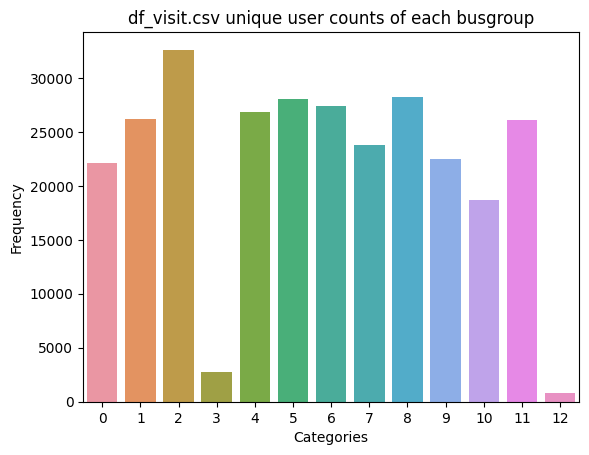

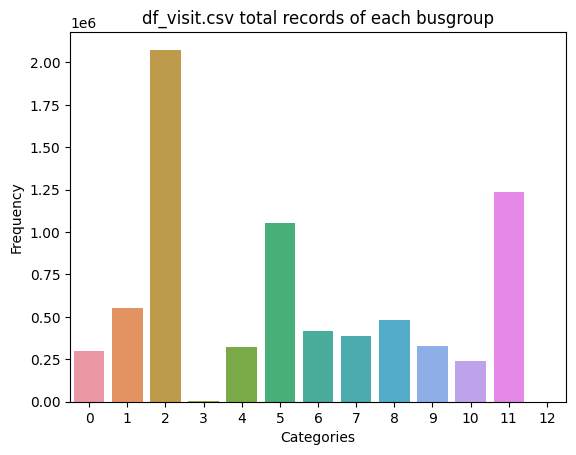

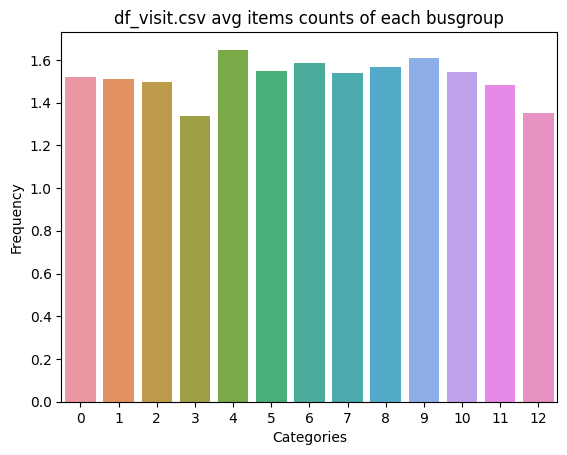

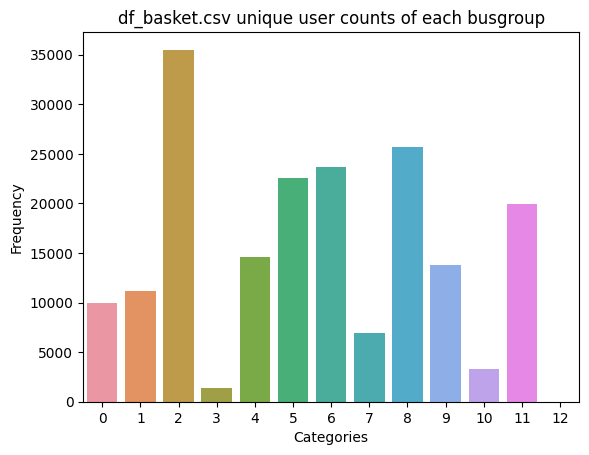

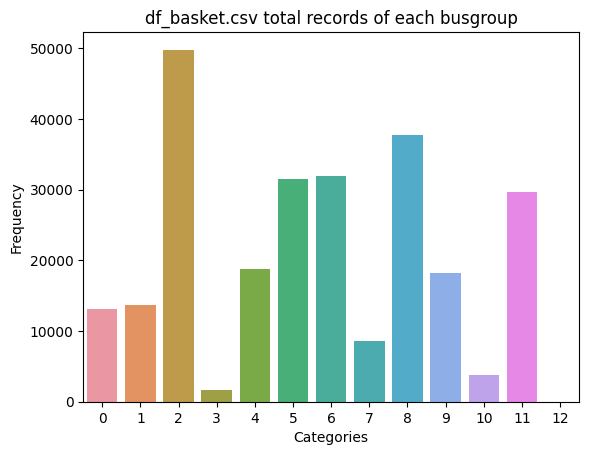

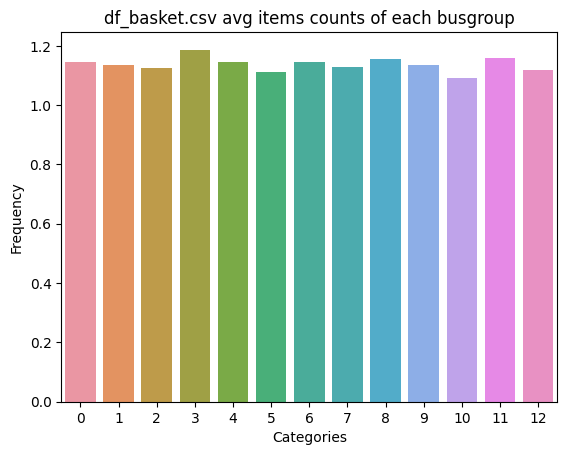

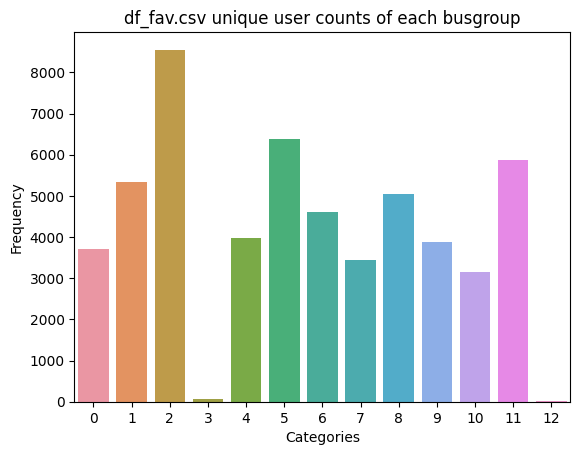

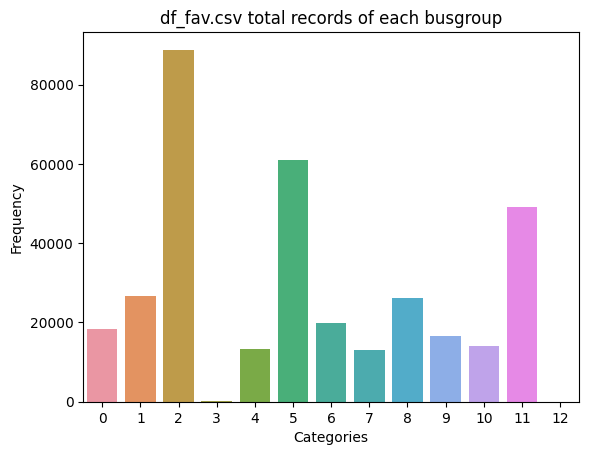

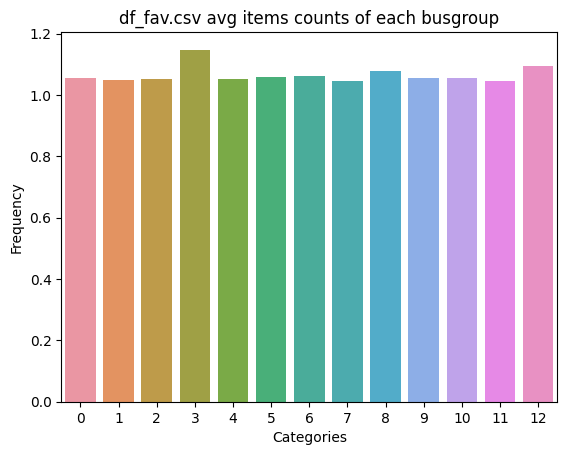

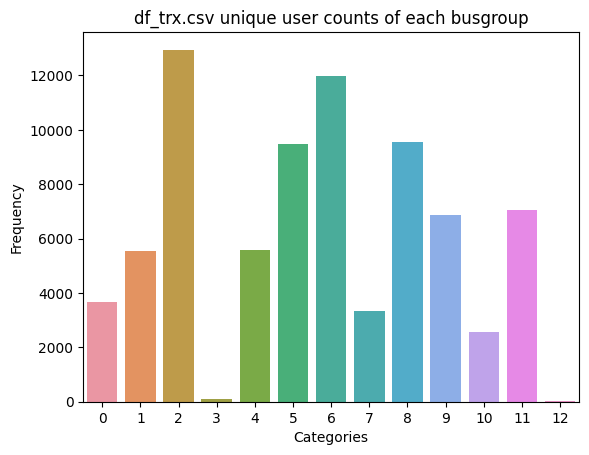

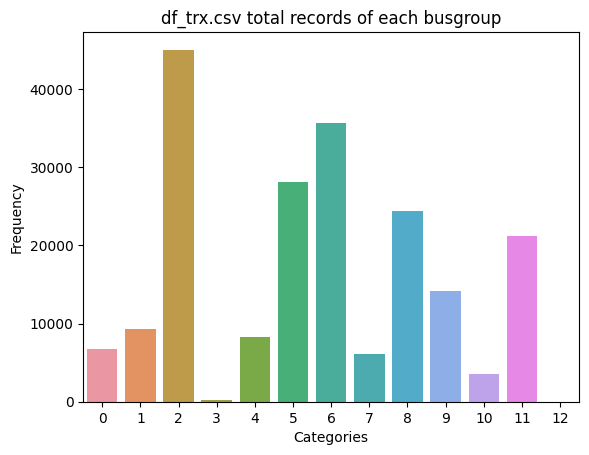

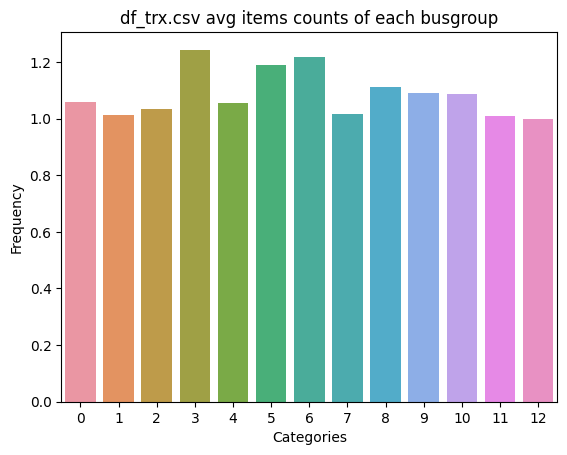

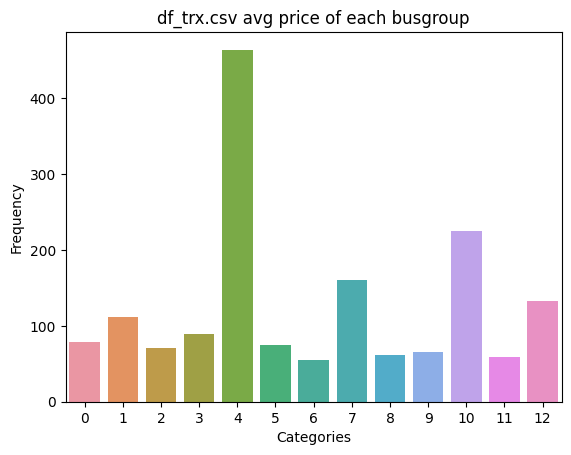

In [2]:
# calculate the train interval for a day
the_day = days[len(days)-5].strftime('%Y-%m-%d')
start_day = (datetime.datetime.strptime(the_day, '%Y-%m-%d')  - timedelta(days=interval)).strftime('%Y-%m-%d')
print(the_day)

for pre, intrctn in zip(["productdetailcount", "addtobasket_count", "fav_count", "quantity"],["df_visit.csv", "df_basket.csv", "df_fav.csv", "df_trx.csv"]):
    
    #filter event data according train interval and get the distributions for unique users', number of records', average of interacted items' at each cat
    intrctn_df = pd.read_pickle(f'./preprocessed/{intrctn}.pkl')
    
    
    df_unique = intrctn_df[(intrctn_df["date"] >= start_day)&(intrctn_df["date"] <= the_day)].groupby("currentbugroupname")["userid"].nunique().reset_index() #unique users'
    df_count = intrctn_df[(intrctn_df["date"] >= start_day)&(intrctn_df["date"] <= the_day)].groupby("currentbugroupname")["userid"].count().reset_index() #number of records'
    df_avg = intrctn_df[(intrctn_df["date"] >= start_day)&(intrctn_df["date"] <= the_day)].groupby("currentbugroupname")[pre].mean().reset_index() #average of interacted items'
    
    #necessary adjustments for the plotting
    cat_mapping = dict(zip(df_unique["currentbugroupname"].tolist(), list(range(len(df_unique["currentbugroupname"].tolist())))))
    cat_df = pd.DataFrame(cat_mapping.items(), columns=["currentbugroupname", "currentbugroupid"])

    for title, col, df in zip([f'{intrctn} unique user counts of each busgroup', f'{intrctn} total records of each busgroup', f'{intrctn} avg items counts of each busgroup'],
                              ['userid', 'userid', pre], [df_unique, df_count, df_avg]):
        
        df_enrich = pd.merge(df, cat_df, how='left', on="currentbugroupname")

        # plot the distribution
        ax = sns.barplot(y = col, x = 'currentbugroupid', data = df_enrich)
        ax.set(xlabel='Categories', ylabel='Frequency', title= title)
        plt.show()

    # price column only in df_trx.csv
    if "df_trx.csv" in intrctn:
        df_avg_v2 = intrctn_df[(intrctn_df["date"] >= start_day)&(intrctn_df["date"] <= the_day)].groupby("currentbugroupname")["price"].mean().reset_index()

        df_enrich = pd.merge(df_avg_v2, cat_df, how='left', on="currentbugroupname")


        ax = sns.barplot(y = "price", x = 'currentbugroupid', data = df_enrich)
        ax.set(xlabel='Categories', ylabel='Frequency', title= f'{intrctn} avg price of each busgroup')
        plt.show()


In [3]:
cat_df

,currentbugroupname,currentbugroupid
0,Aksesuar & Saat & Gözlük,0
1,Ayakkabı & Çanta,1
2,Branded Tekstil,2
3,Digital Goods,3
4,Elektronik,4
5,Ev,5
6,FMCG,6
7,GAS,7
8,GM,8
9,Kozmetik,9


## Insights:

    - According to plots above, categories' popularities are varies. So, number unique users and records caount can be informative features. Any feature that show busgroup popularity
    - Avg interacted items dont differ according to busgroup. All the users interacted with one-two items from busgroup

## Features

    - busgroup features: fav unique users/visit unique users, add2basket unique users/visit unique users, purchased unique users/visit unique users, fav records/visit records, add2basket records/visit records, purchased records/visit records

        - Including features that shows cr, ctr like attributes of busgroup. These features kind of represent demand and satisfaction level of the busgroup

    - user-busgroup features: avg fav, visit, purchased number at train interval for a given user-busgroup, how close user age and busgroup average age, contain same gender items, how close user spended price in train interval with the busgroup avg price




In [4]:
# shows that whether row gender in currentbugroupname gender
def same_gender_func(row):
    if row["gender"] in row["currentbugroupname_gender"]:
        return 1
    return 0

# shows that whether row age group in currentbugroupname age group
def same_age_func(row):
    if row["age_group"] in row["currentbugroupname_age"]:
        return 1
    return 0


def meta_enrichment_pair(pair_df, train_start, train_end, user_meta, busgroup_meta, purchased_df):

    
    filtered_purchased_df = purchased_df[(purchased_df["date"] >= train_start)&(purchased_df["date"] <= train_end)]

    #get price features
    user_price_features = filtered_purchased_df.groupby("userid")["price"].mean().reset_index().rename(columns={"price":"user_price"})
    busgroup_price_features = filtered_purchased_df.groupby("currentbugroupname")["price"].mean().reset_index().rename(columns={"price":"currentbugroupname_price"})

    # enrich train/test pairs with 
    print("1 before left join", pair_df.shape)
    pair_df = pd.merge(pair_df, user_meta, how = "left", on ="userid")
    print("1 after left join", pair_df.shape)

    print("2 before left join", pair_df.shape)
    pair_df = pd.merge(pair_df, busgroup_meta, how = "left", on ="currentbugroupname")
    print("2 after left join", pair_df.shape)

    print("3 before left join", pair_df.shape)
    pair_df = pd.merge(pair_df, user_price_features, how = "left", on ="userid")
    print("3 after left join", pair_df.shape)

    print("4 before left join", pair_df.shape)
    pair_df = pd.merge(pair_df, busgroup_price_features, how = "left", on ="currentbugroupname")
    print("4 after left join", pair_df.shape)

    #print(pair_df.columns.values)

    # create fetures that shows how close user age and busgroup average age, contain same gender items, how close user spended price in train interval with the busgroup avg price
    pair_df["same_gender"] = pair_df.apply(lambda x : same_gender_func(x), axis = 1)
    pair_df["same_age"] = pair_df.apply(lambda x : same_age_func(x), axis = 1)
    pair_df["price_ratio"] = pair_df["user_price"]/pair_df["currentbugroupname_price"]

    return pair_df[["userid", "currentbugroupname", "same_gender", "same_age", "price_ratio", "label"]]



In [5]:
def aggregate_user_features(groupby_cols, df_list, features):

    user_interest = []
    
    for df, feat in zip(df_list, features):

        user_interest_df = df.groupby(groupby_cols)[feat].mean().reset_index().rename(columns={feat:f'user_busgroup_avg_{feat}'}) # user-busgroup pair avg fav, visit, purchased item count
        bugroup_interest_df = df.groupby("currentbugroupname")[feat].mean().reset_index().rename(columns={feat:f'bugroupname_avg_{feat}'}) # busgroup avg fav, visit, purchased item count
        
        merge = pd.merge(user_interest_df, bugroup_interest_df, how='left', on="currentbugroupname")
        merge[f'user_busgroup_avg_{feat}_ratio'] = merge[f'user_busgroup_avg_{feat}']/merge[f'bugroupname_avg_{feat}'] # fraction of a pair avg fav, visit, purchased item count based on  avg fav, visit, purchased item count of busgroup


        selected_feats = groupby_cols + [f'user_busgroup_avg_{feat}_ratio']
        user_interest.append(merge[selected_feats])

    whole_pairs = pd.concat(user_interest)[groupby_cols]
    whole_pairs.drop_duplicates(inplace=True)

    # gather pairs with their features
    for i in range(0, len(user_interest)):
        whole_pairs = pd.merge(whole_pairs, user_interest[i], how='left', on=groupby_cols)

    return whole_pairs.fillna(0)



def aggregate_bugroup_features(groupby_cols, df_list, prefix):

    bugroup_features = []
    bugroup_features_v2 = []

    for df, pr in zip(df_list, prefix):
        bugroup_features.append(df.groupby(groupby_cols)["userid"].nunique().reset_index().rename(columns={'userid':f'unique_userid_{pr}'})) # number of unique users for each busgroup
        bugroup_features_v2.append(df.groupby(groupby_cols).size().reset_index().rename(columns={0:f'{pr}_records'})) # number of records for each busgroup

    whole = pd.concat(bugroup_features)[groupby_cols]
    whole.drop_duplicates(inplace=True)

    # gather busgroups with their features
    for i in range(0, len(bugroup_features)):
        whole = pd.merge(whole, bugroup_features[i], how='left', on=groupby_cols)
        whole = pd.merge(whole, bugroup_features_v2[i], how='left', on=groupby_cols)

    #whole = whole.fillna(0)
    
    # cr/ctr like calculation
    for pr in prefix:
        
        if pr != "visit":
            whole[f'unique_userid_{pr}_ratio'] = whole[f'unique_userid_{pr}']/whole[f'unique_userid_visit']
            whole[f'{pr}_records_ratio'] = whole[f'{pr}_records']/whole[f'visit_records']

    selected_feats = [x for x in whole.columns.values if "ratio" in x]
    selected_feats = selected_feats + groupby_cols
    #whole = whole.drop(['unique_userid_visit', f'visit_records'], axis=1)

    return whole[selected_feats].fillna(0)






In [6]:
# read product and user meta data
my_user_meta = pd.read_pickle("./preprocessed/df_demo.csv.pkl")
my_product_meta = pd.read_pickle("./preprocessed/df_product.csv.pkl")

# read purchased data for price info
my_purchased_df = pd.read_pickle("./preprocessed/df_trx.csv.pkl")
print("reading pickles")

#get average gender and age info of buscat
busgroup_gender = my_product_meta.groupby(["currentbugroupname"])["gender"].apply(list).reset_index().rename(columns={"gender":"currentbugroupname_gender"})
busgroup_age = my_product_meta.groupby(["currentbugroupname"])["age"].apply(list).reset_index().rename(columns={"age":"currentbugroupname_age"})
my_busgroup_meta = pd.merge(busgroup_gender, busgroup_age , how="inner", on= "currentbugroupname")

print("bus group meta handled")




for the_day in days:

    df_list = []
    features = []
    prefix = []

    the_day = the_day.strftime('%Y-%m-%d')
    start_day = (datetime.datetime.strptime(the_day, '%Y-%m-%d')  - timedelta(days=interval)).strftime('%Y-%m-%d')
    print(the_day)

    for intrctn in ["df_visit.csv", "df_basket.csv", "df_fav.csv", "df_trx.csv"]:
        
        #filter event data according train interval
        intrctn_df = pd.read_pickle(f'./preprocessed/{intrctn}.pkl')
        df_list.append(intrctn_df[(intrctn_df["date"] >= start_day)&(intrctn_df["date"] <= the_day)])

        #print(intrctn_df[(intrctn_df["date"] >= start_day)&(intrctn_df["date"] <= the_day)].shape[0])

        # gather necessary infos for feature engineering
        if "visit" in intrctn:
            features.append("productdetailcount")
            prefix.append("visit")
        
        elif "basket" in intrctn:
            features.append("addtobasket_count")
            prefix.append("basket")

        elif "fav" in intrctn:
            features.append("fav_count")
            prefix.append("fav")
        
        elif "trx" in intrctn:
            features.append("quantity")
            prefix.append("trx")


    # first feature engineering
    user_bugroup_feats = aggregate_user_features(["userid", "currentbugroupname"], df_list, features)
    bugroup_feats = aggregate_bugroup_features(["currentbugroupname"], df_list, prefix)



    train_test = []
    for split in ["df_target_train.csv", "df_test.csv"]:

        if "train" in split:
            fold = "train"
        else:
            fold = "test"

        split_df = pd.read_pickle(f'{path}{split}_{the_day}.pkl')
        split_df = meta_enrichment_pair(split_df, start_day, the_day, my_user_meta, my_busgroup_meta, my_purchased_df)

        split_df = pd.merge(split_df, user_bugroup_feats, how='left', on=["userid", "currentbugroupname"])
        split_df = pd.merge(split_df, bugroup_feats, how='left', on=["currentbugroupname"])
        split_df = split_df.dropna()
        #print(split_df.shape)
        
        split_df["split"] = fold
        train_test.append(split_df)


    train_test_df = pd.concat(train_test)
    train_test_df.to_pickle(f'{path}train_test_df_{the_day}.pkl')


reading pickles
bus group meta handled
2020-10-01
1 before left join (4397, 3)
1 after left join (4397, 7)
2 before left join (4397, 7)
2 after left join (4397, 9)
3 before left join (4397, 9)
3 after left join (4397, 10)
4 before left join (4397, 10)
4 after left join (4397, 11)
1 before left join (23344, 3)
1 after left join (23344, 7)
2 before left join (23344, 7)
2 after left join (23344, 9)
3 before left join (23344, 9)
3 after left join (23344, 10)
4 before left join (23344, 10)
4 after left join (23344, 11)
2020-10-02
1 before left join (4302, 3)
1 after left join (4302, 7)
2 before left join (4302, 7)
2 after left join (4302, 9)
3 before left join (4302, 9)
3 after left join (4302, 10)
4 before left join (4302, 10)
4 after left join (4302, 11)
1 before left join (22146, 3)
1 after left join (22146, 7)
2 before left join (22146, 7)
2 after left join (22146, 9)
3 before left join (22146, 9)
3 after left join (22146, 10)
4 before left join (22146, 10)
4 after left join (22146, 11)

In [7]:
split_df = pd.read_pickle(f'{path}{split}_{the_day}.pkl')
split_df.columns.values

array(['userid', 'currentbugroupname', 'label'], dtype=object)

In [8]:
train_test_df.columns.values

array(['userid', 'currentbugroupname', 'same_gender', 'same_age',
       'price_ratio', 'label',
       'user_busgroup_avg_productdetailcount_ratio',
       'user_busgroup_avg_addtobasket_count_ratio',
       'user_busgroup_avg_fav_count_ratio',
       'user_busgroup_avg_quantity_ratio', 'unique_userid_basket_ratio',
       'basket_records_ratio', 'unique_userid_fav_ratio',
       'fav_records_ratio', 'unique_userid_trx_ratio',
       'trx_records_ratio', 'split'], dtype=object)

# Check classs dist

In [9]:
for col in train_test_df.columns:
    
    if col not in ["userid", "currentbugroupname", "label", "split"]:
        print(col)
        display(train_test_df[col].describe())

same_gender


count    27703.000000
mean         0.713388
std          0.452187
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: same_gender, dtype: float64

same_age


count    27703.000000
mean         0.711800
std          0.452933
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: same_age, dtype: float64

price_ratio


count    27703.000000
mean         1.281221
std          3.391075
min          0.006446
25%          0.536853
50%          0.853094
75%          1.303715
max        163.051020
Name: price_ratio, dtype: float64

user_busgroup_avg_productdetailcount_ratio


count    27703.000000
mean         0.998214
std          0.324007
min          0.000000
25%          0.779807
50%          0.931714
75%          1.137318
max          9.188106
Name: user_busgroup_avg_productdetailcount_ratio, dtype: float64

user_busgroup_avg_addtobasket_count_ratio


count    27703.000000
mean         0.009552
std          0.102993
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.456043
Name: user_busgroup_avg_addtobasket_count_ratio, dtype: float64

user_busgroup_avg_fav_count_ratio


count    27703.000000
mean         0.304928
std          0.472594
min          0.000000
25%          0.000000
50%          0.000000
75%          0.944806
max          8.393224
Name: user_busgroup_avg_fav_count_ratio, dtype: float64

user_busgroup_avg_quantity_ratio


count    27703.000000
mean         0.536337
std          0.550170
min          0.000000
25%          0.000000
50%          0.818226
75%          0.968243
max          8.967782
Name: user_busgroup_avg_quantity_ratio, dtype: float64

unique_userid_basket_ratio


count    27703.000000
mean         0.792704
std          0.289430
min          0.183503
25%          0.567035
50%          0.833321
75%          0.945177
max          1.158379
Name: unique_userid_basket_ratio, dtype: float64

basket_records_ratio


count    27703.000000
mean         0.038011
std          0.025262
min          0.015400
25%          0.022179
50%          0.024022
75%          0.055863
max          0.384630
Name: basket_records_ratio, dtype: float64

unique_userid_fav_ratio


count    27703.000000
mean         0.211078
std          0.042701
min          0.021652
25%          0.171856
50%          0.211488
75%          0.234070
max          0.270623
Name: unique_userid_fav_ratio, dtype: float64

fav_records_ratio


count    27703.000000
mean         0.047067
std          0.007627
min          0.014111
25%          0.042462
50%          0.046601
75%          0.054116
max          0.060183
Name: fav_records_ratio, dtype: float64

unique_userid_trx_ratio


count    27703.000000
mean         0.317245
std          0.098401
min          0.041972
25%          0.223298
50%          0.348615
75%          0.416415
max          0.450511
Name: unique_userid_trx_ratio, dtype: float64

trx_records_ratio


count    27703.000000
mean         0.030221
std          0.020348
min          0.014070
25%          0.016678
50%          0.020799
75%          0.025840
max          0.084987
Name: trx_records_ratio, dtype: float64

# Check class distribution of generated metrics

same_gender


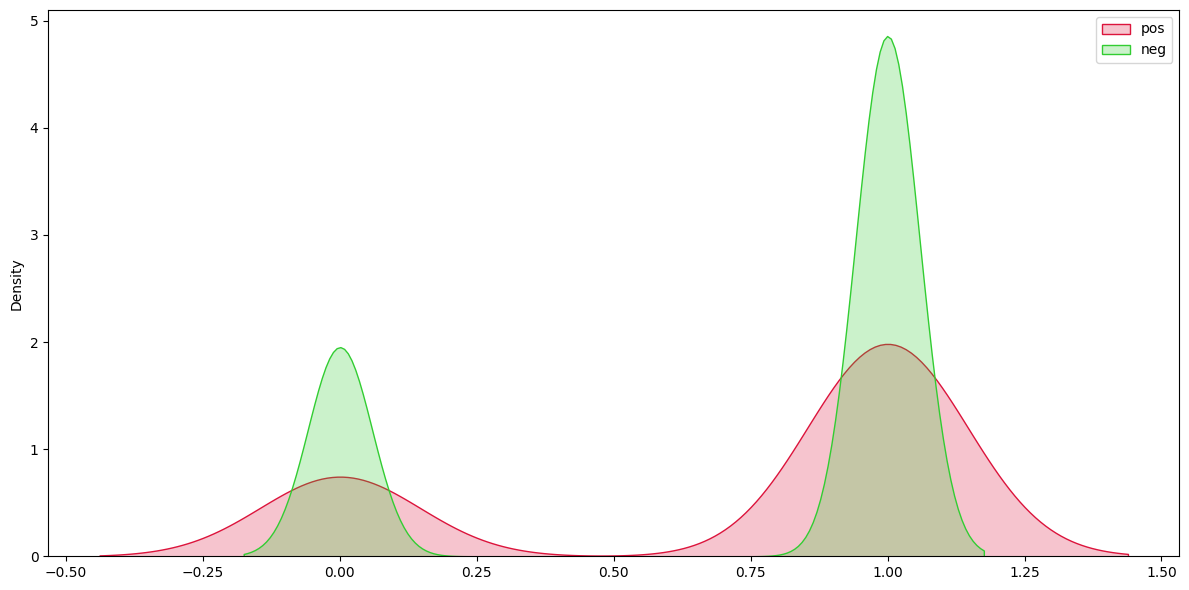

same_age


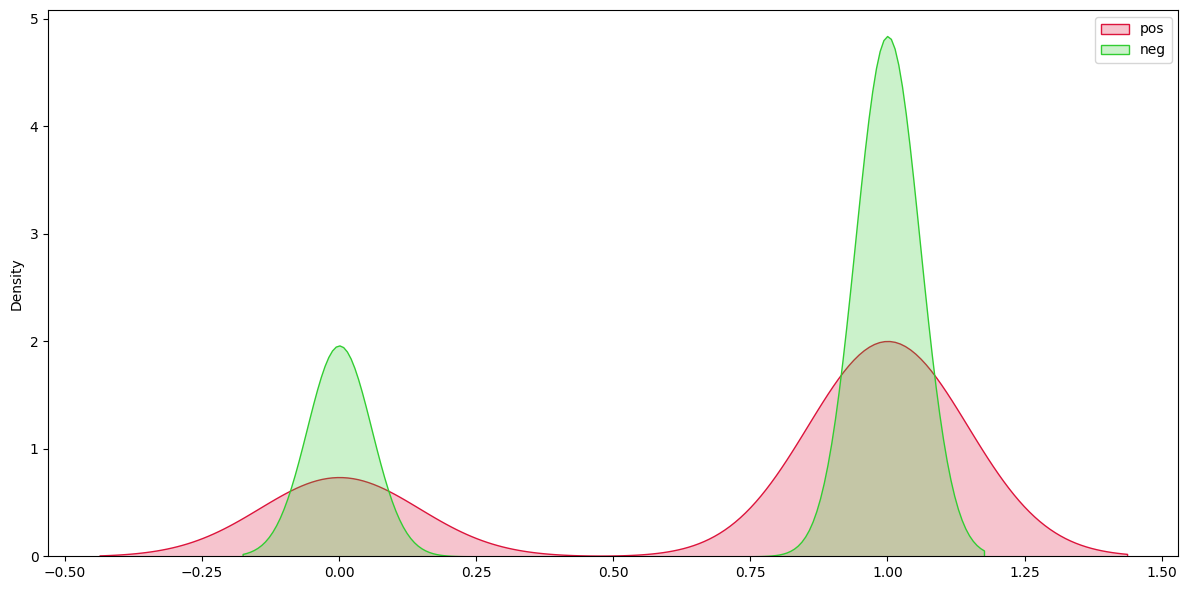

price_ratio


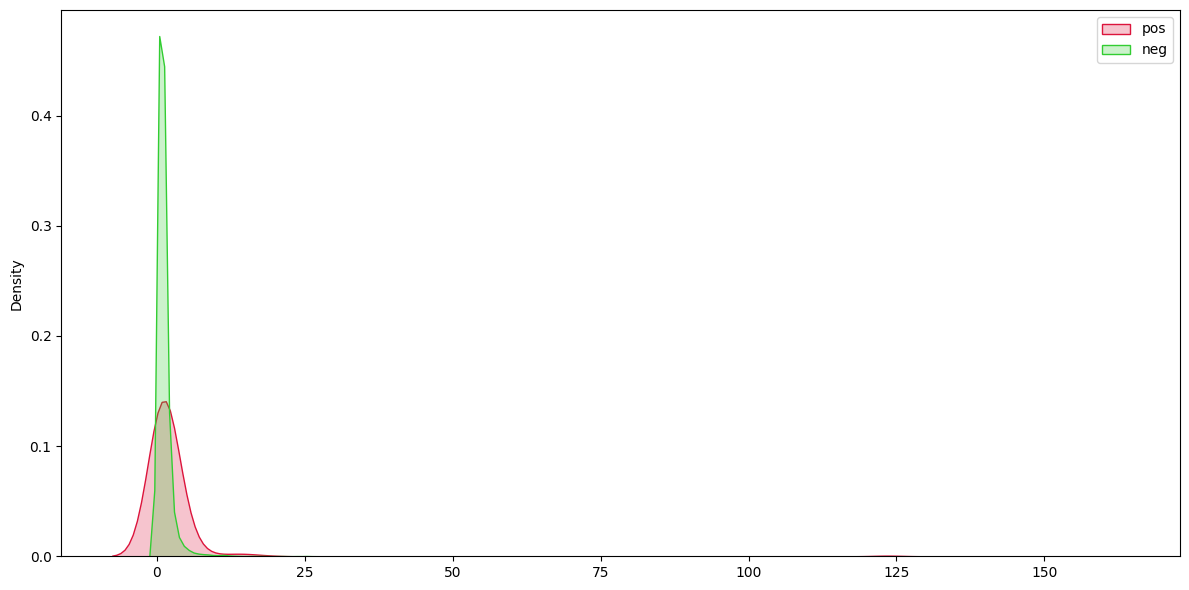

user_busgroup_avg_productdetailcount_ratio


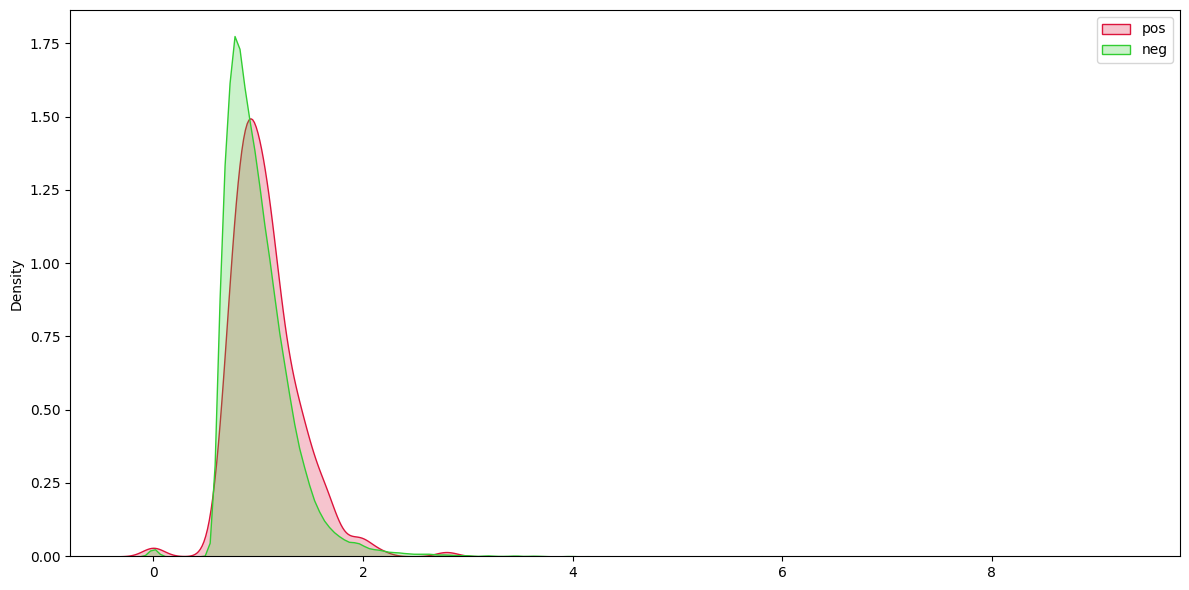

user_busgroup_avg_addtobasket_count_ratio


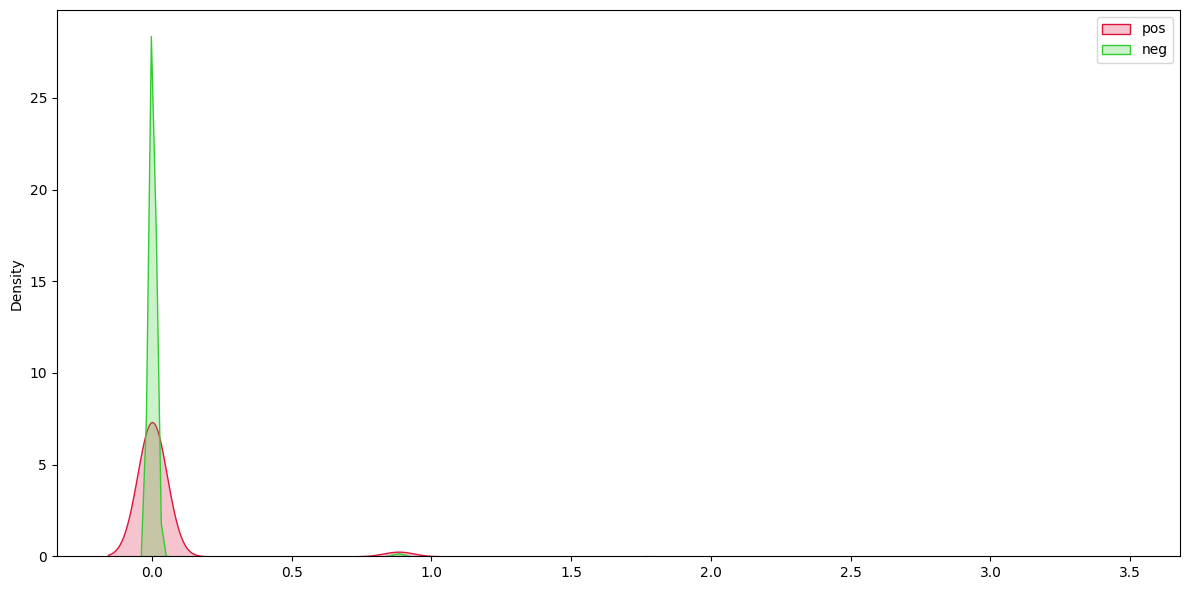

user_busgroup_avg_fav_count_ratio


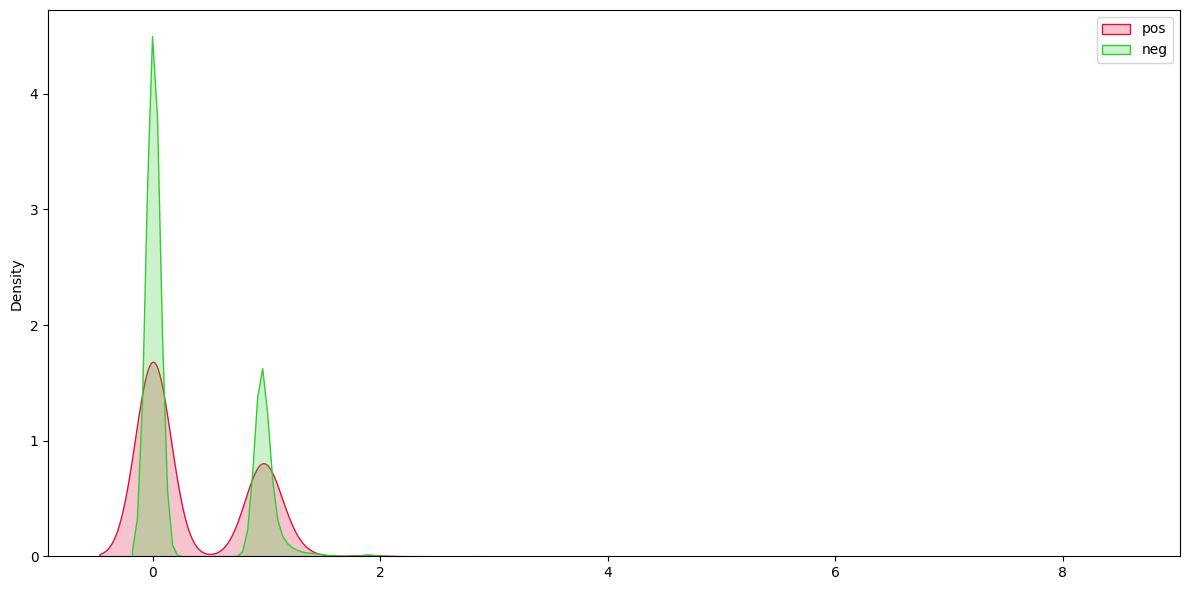

user_busgroup_avg_quantity_ratio


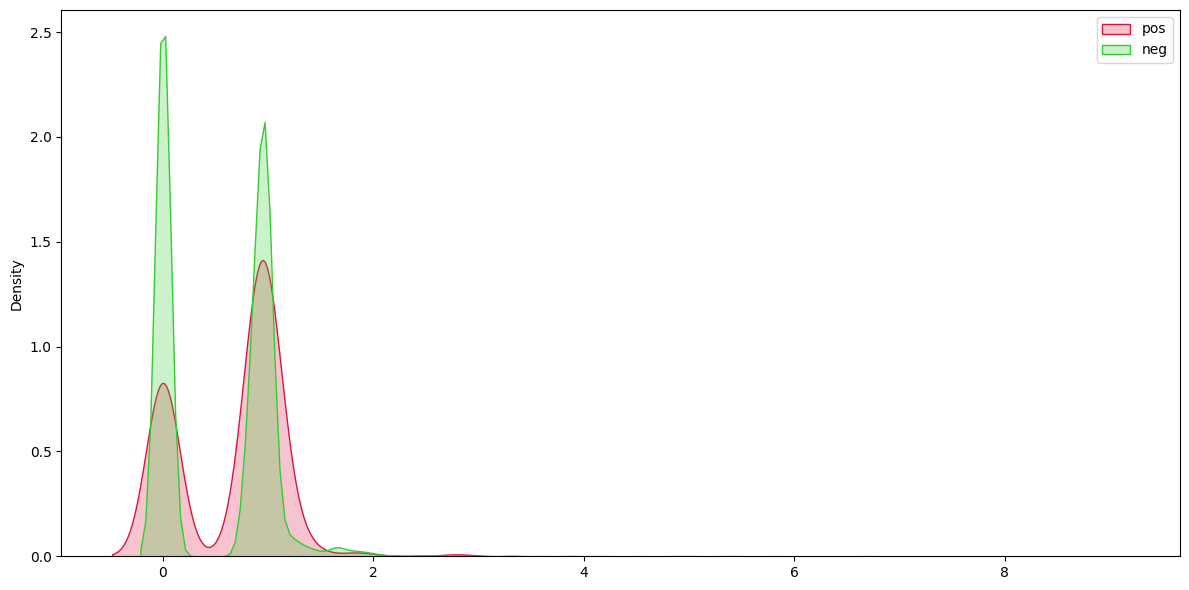

unique_userid_basket_ratio


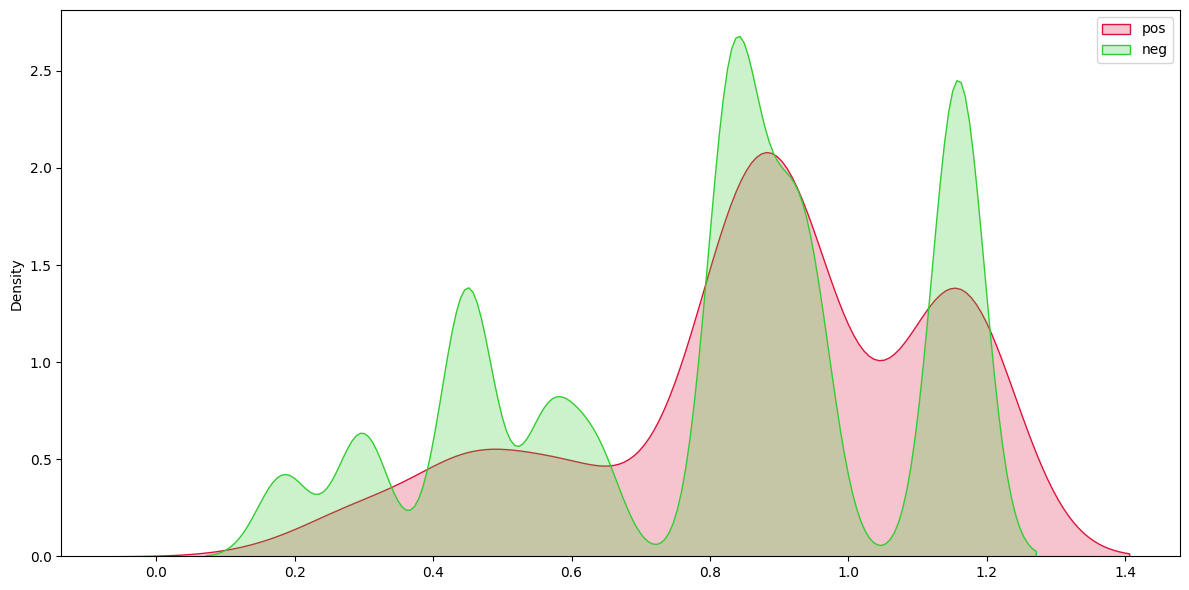

basket_records_ratio


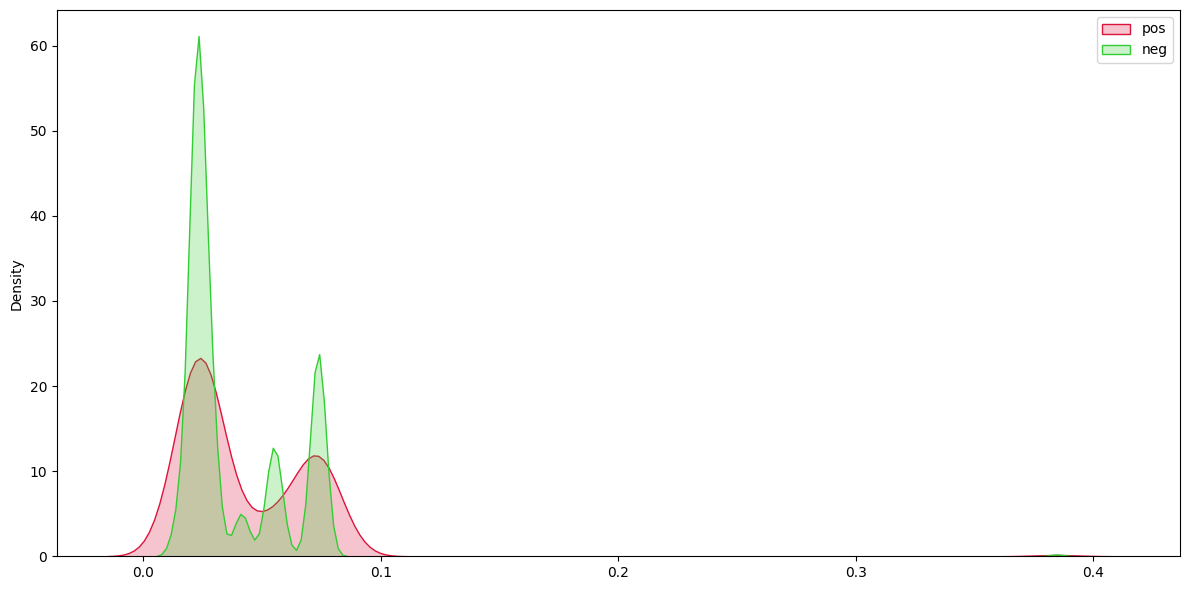

unique_userid_fav_ratio


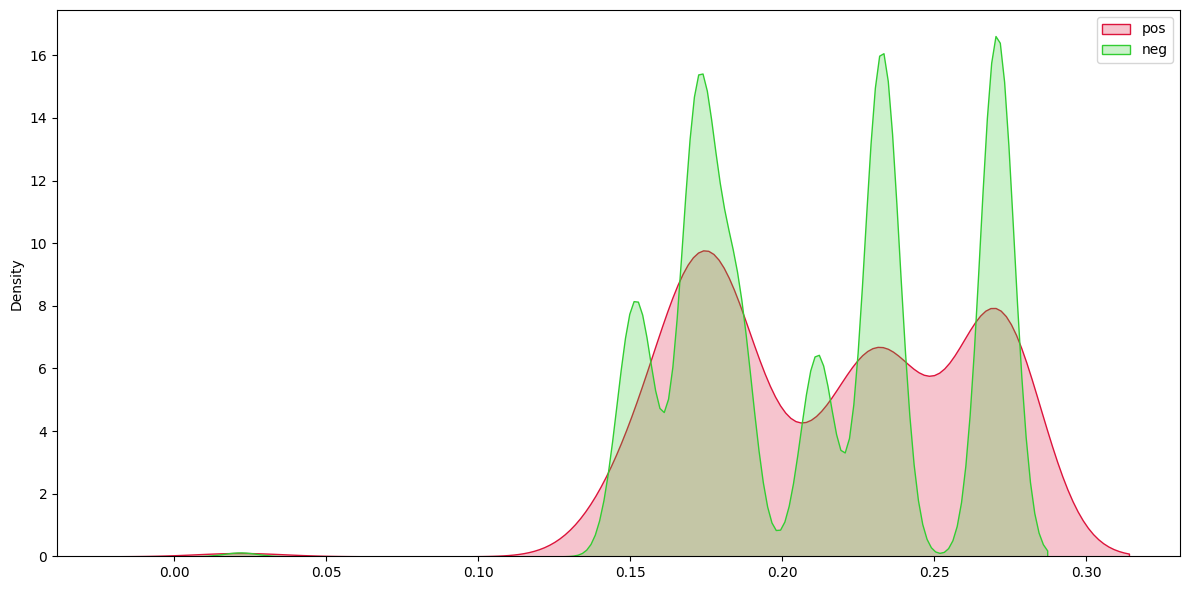

fav_records_ratio


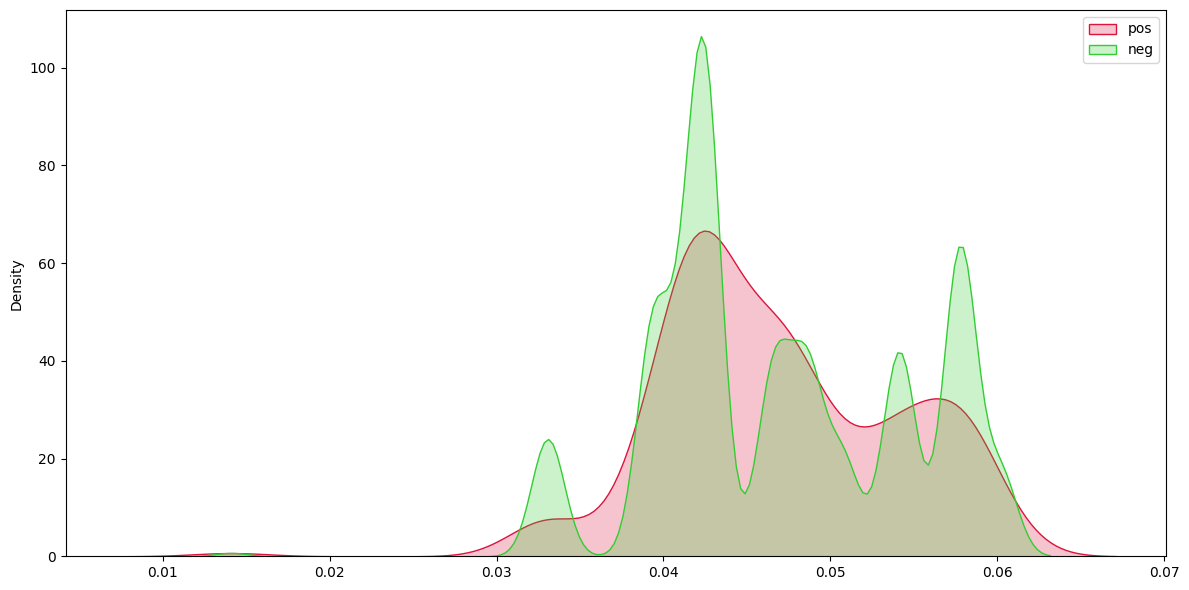

unique_userid_trx_ratio


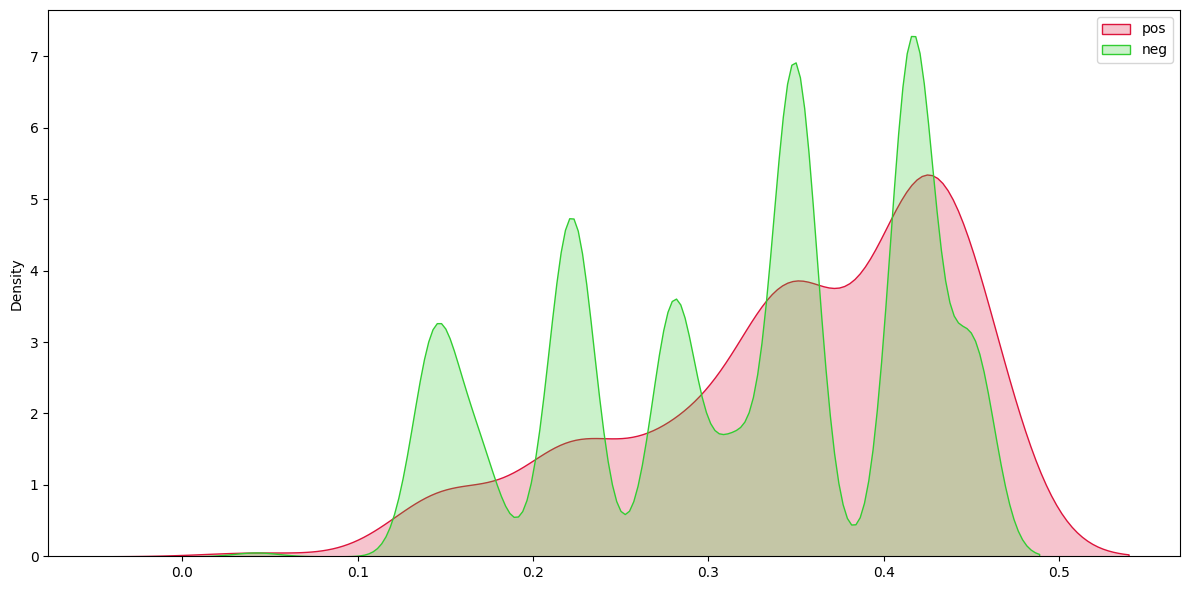

trx_records_ratio


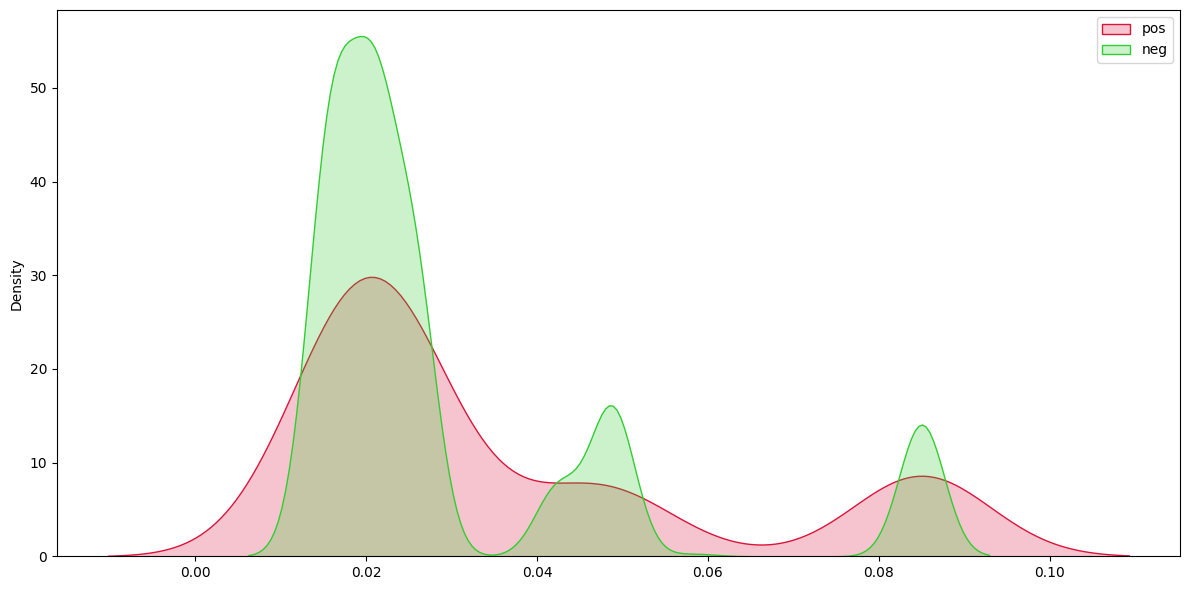

In [10]:
for col in train_test_df.columns:
    if col not in ["userid", "currentbugroupname", "label", "split"]:
        print(col)
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.kdeplot(data=train_test_df[train_test_df["label"]==1][col].values,
                    color='crimson', label='pos', fill=True, ax=ax)
        sns.kdeplot(data=train_test_df[train_test_df["label"]==0][col].values,
                    color='limegreen', label='neg', fill=True, ax=ax)
        ax.legend()
        plt.tight_layout()
        plt.show()

## From above plots, it seems that distributions of the neg and positive classes have some differences 

# Generating df_test.csv features

In [11]:
test_df_list = []
for intrctn in ["df_visit.csv", "df_basket.csv", "df_fav.csv", "df_trx.csv"]:
        
        #filter event data according train interval
        intrctn_df = pd.read_pickle(f'./preprocessed/{intrctn}.pkl')
        test_df_list.append(intrctn_df)

# first feature engineering
user_bugroup_feats = aggregate_user_features(["userid", "currentbugroupname"], test_df_list, ["productdetailcount", "addtobasket_count", "fav_count", "quantity"])
bugroup_feats = aggregate_bugroup_features(["currentbugroupname"], test_df_list, ["visit", "basket", "fav", "trx"])

# read test df and enrich with their features
test_split_df = pd.read_pickle(f'./preprocessed/df_test.csv.pkl')
test_split_df["label"] = 0
test_split_df = meta_enrichment_pair(test_split_df, "2020-10-01", "2020-11-01", my_user_meta, my_busgroup_meta, my_purchased_df)

test_split_df = pd.merge(test_split_df, user_bugroup_feats, how='left', on=["userid", "currentbugroupname"])
test_split_df = pd.merge(test_split_df, bugroup_feats, how='left', on=["currentbugroupname"])
test_split_df = test_split_df.dropna()
test_split_df.to_pickle(f'{path}df_test_features.csv.pkl')

1 before left join (230592, 5)
1 after left join (230592, 9)
2 before left join (230592, 9)
2 after left join (230592, 11)
3 before left join (230592, 11)
3 after left join (230592, 12)
4 before left join (230592, 12)
4 after left join (230592, 13)


In [12]:
test_split_df.head(100)

,userid,currentbugroupname,same_gender,same_age,price_ratio,label,user_busgroup_avg_productdetailcount_ratio,user_busgroup_avg_addtobasket_count_ratio,user_busgroup_avg_fav_count_ratio,user_busgroup_avg_quantity_ratio,unique_userid_basket_ratio,basket_records_ratio,unique_userid_fav_ratio,fav_records_ratio,unique_userid_trx_ratio,trx_records_ratio
0,20152944,Private Label,1,1,0.720743,0,1.319804,0.0,0.957355,0.992244,0.833321,0.024022,0.231375,0.039375,0.28146,0.016747
1,6662068,Private Label,0,0,1.530601,0,1.851026,0.0,0.000000,0.992244,0.833321,0.024022,0.231375,0.039375,0.28146,0.016747
2,11941706,Private Label,0,0,1.240587,0,1.019453,0.0,0.000000,0.992244,0.833321,0.024022,0.231375,0.039375,0.28146,0.016747
4,20939786,Private Label,1,1,0.527476,0,1.076960,0.0,0.000000,0.000000,0.833321,0.024022,0.231375,0.039375,0.28146,0.016747
5,15519602,Private Label,1,1,0.864606,0,1.346200,0.0,0.000000,0.000000,0.833321,0.024022,0.231375,0.039375,0.28146,0.016747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,20016374,Private Label,0,0,1.904103,0,0.673100,0.0,0.957355,0.992244,0.833321,0.024022,0.231375,0.039375,0.28146,0.016747
163,32370954,Private Label,0,0,1.247710,0,0.878770,0.0,0.000000,0.000000,0.833321,0.024022,0.231375,0.039375,0.28146,0.016747
167,26144552,Private Label,0,0,0.856852,0,2.692401,0.0,0.000000,0.000000,0.833321,0.024022,0.231375,0.039375,0.28146,0.016747
168,38801084,Private Label,0,0,2.153918,0,2.019301,0.0,0.000000,0.992244,0.833321,0.024022,0.231375,0.039375,0.28146,0.016747
